In [1]:
import sys
import os
import math
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn, get_image_coordinates, get_image_velocity
from model.layers.Spline import NaturalCubicSpline
from model.layers.ODE import ODE

In [2]:
tfrecord_path = '../../data1/waymo_dataset/uncompressed/tf_example/validation'
idx_path = '../../idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: waymo_collate_fn(x))
road_map, agent_trajectories, unobserved_positions, future_times, target_velocity, target_occupancy_grid = next(iter(dataloader))

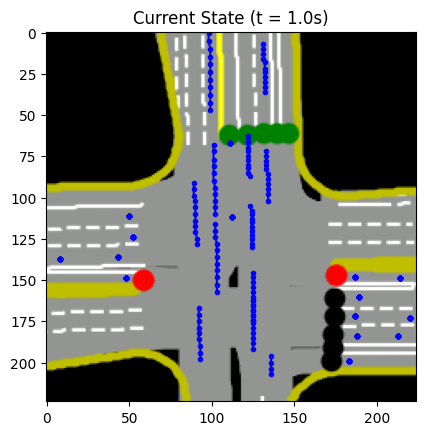

In [3]:
image_buffer = road_map[0].numpy() / 255.0
GRID_SIZE = image_buffer.shape[0]

plt.title('Current State (t = 1.0s)')
plt.imshow(image_buffer)
#plt.axis('off')

agent_cmap = ['blue', 'orange', 'yellow', 'purple']

trajectories = get_image_coordinates(agent_trajectories[0,:,:,:2])
for agent in range(trajectories.shape[0]):
    agent_trajectory = trajectories[agent, :, :]
    agent_type = agent_trajectories[0,agent,-1,-1].item()
    agent_type = 4 if math.isnan(agent_type) else int(agent_type)
    agent_color = agent_cmap[agent_type - 1]
    plt.plot(agent_trajectory[:, 0], agent_trajectory[:, 1], marker='o', markersize=3, color=agent_color)

plt.show()

In [4]:
def group_indices(tensor):
    groups = defaultdict(list)
    tensor = torch.round(tensor * 10)
    for idx, val in enumerate(tensor):
        val = val.item() / 10
        groups[val].append(idx)
    return groups

positions = unobserved_positions[0] 
times = future_times[0] 
velocity = target_velocity[0]

groups = group_indices(times)
sorted_keys = sorted(groups.keys())

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.imshow(image_buffer)

    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(GRID_SIZE, 0)

    time = list(sorted_keys)[frame]
    indices = groups[time]
    
    group_positions = get_image_coordinates(positions[indices])
    group_velocity = get_image_velocity(velocity[indices])

    ax.set_title(f"Future Flow (t = {time}s)")
    
    x_coords, y_coords = zip(*group_positions)
    ax.scatter(x_coords, y_coords, marker='o', s=5, color='blue')
    ax.quiver(x_coords, y_coords, group_velocity[:, 0], group_velocity[:, 1], 
              angles='xy', scale_units='xy', scale=1, color='orange')

anim = FuncAnimation(fig, update, frames=len(groups), repeat=False)

plt.close(fig)

HTML(anim.to_jshtml())

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
positions = positions.to(device)
times = times.to(device)
velocity = velocity.to(device)

BATCH_SIZE = 1024
num_batches = times.shape[0] // BATCH_SIZE
positions_batches = positions[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)
times_batches = times[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)
velocity_batches = velocity[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)
print(times.shape)
print(times_batches.shape)

flow_field = ODE(2, 0, (512 for _ in range(4)), 128).to(device)
flow_field.train()

optim = torch.optim.Adam(flow_field.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

EPOCHS = 1000
for epoch in range(EPOCHS):
    for batch in range(times_batches.shape[0]):
        p = positions_batches[batch]
        t = times_batches[batch]
        v = velocity_batches[batch]

        flow = flow_field(t, p, None)
        loss = F.mse_loss(flow, v)

        optim.zero_grad()
        loss.backward()
        optim.step()

        print(loss)

    scheduler.step()

torch.Size([23660, 1])
torch.Size([23, 1024, 1])


/tmp/ipykernel_1082260/1992119965.py:27: UserWarning: Using a target size (torch.Size([1024, 2])) that is different to the input size (torch.Size([1024, 1024, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(flow, v)


tensor(29.0534, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(43.7480, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(62.1321, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.8051, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(14.4286, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(90.7654, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(23.7064, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.0833, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.2596, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(18.0290, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.7490, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(50.8699, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.2150, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.2216, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0636, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9367, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6871, device='cuda:0', 

/tmp/ipykernel_1076152/1929136137.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


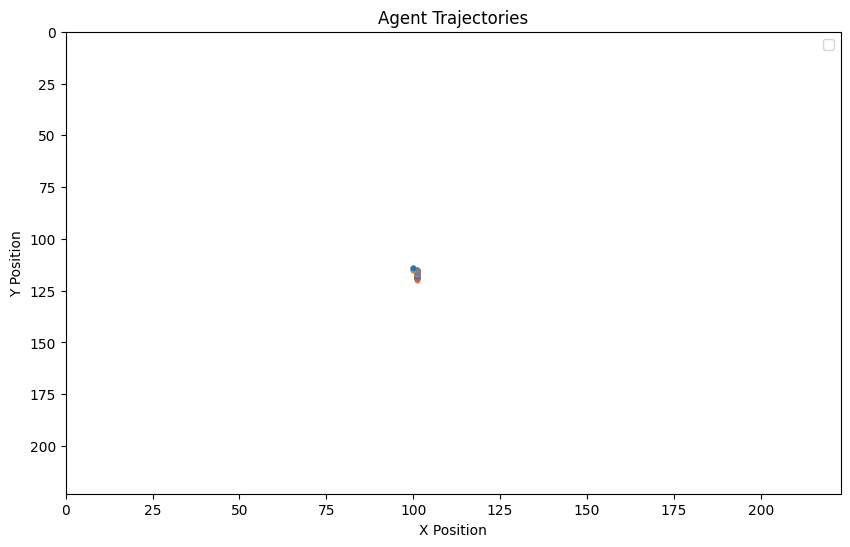

In [5]:
trajectories = agent_trajectories[:,:,:,:2]
batch, num_agents, seq_len, num_features = trajectories.shape
t = torch.linspace(0., 1., seq_len).to(agent_trajectories)
spline = NaturalCubicSpline(t, trajectories)

plt.figure(figsize=(10, 6))

SAMPLING_FREQUENCY = 100
for i in range(SAMPLING_FREQUENCY+1):
    t = i / SAMPLING_FREQUENCY
    positions = get_image_coordinates(spline.evaluate(t))
    plt.plot(positions[0,0,0].cpu().numpy(), positions[0,0,1].cpu().numpy(), 'o-', markersize=3)
    #plt.scatter(positions[:,:,0].cpu().numpy(), positions[:,:,1].cpu().numpy(), 'o-', markersize=3)

plt.xlim(0, 223)
plt.ylim(0, 223)

plt.gca().invert_yaxis()

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectories')
plt.legend()
plt.show()